In [1]:
%load_ext autoreload
%autoreload 2
from proj1_helpers import *
from implementations import * 
from cleaning import *
from cross_validation import *
from simulation import *
import matplotlib.pyplot as plt

In [2]:
data_path = "data/train.csv"

In [3]:
y, x, ids = load_csv_data(data_path, sub_sample=False)

## Exploratory Data Analysis

All features are numeric. The number of jets is discrete.

#### Distribution of the features
Let's look at the distribution of some of the features.

In [4]:
def plot_histogram(x, col_idx):
    plt.hist(x[:, col_idx], bins=100, log=True)
    
    plt.title(f'Histogram of feature index {col_idx}')
    plt.ylabel('Counts (log scale)')
    plt.xlabel('Values')
    plt.show()
    
def double_histograms(x, idx_1, idx_2):
    fig, ax = plt.subplots(1, 2, sharey='row',figsize=(15,5))

    ax[0].hist(x[:, idx_1], bins=100, log=True)
    ax[1].hist(x[:, idx_2], bins=100, log=True)
    plt.tight_layout()


    ax[0].set_title(f'Histogram of feature index {idx_1}')
    ax[0].set_ylabel('Counts (log scale)')
    ax[0].set_xlabel('Values')

    ax[1].set_title(f'Histogram of feature index {idx_2}')
    ax[1].set_ylabel('Counts (log scale)')
    ax[1].set_xlabel('Values')

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

def quad_histograms(x, idx_1, idx_2, idx_3, idx_4):
    fig, ax = plt.subplots(2, 2, sharey='row',figsize=(15,10))

    ax[0,0].hist(x[:, idx_1], bins=100, log=True)
    ax[0,1].hist(x[:, idx_2], bins=100, log=True)
    ax[1,0].hist(x[:, idx_3], bins=100, log=True)
    ax[1,1].hist(x[:, idx_4], bins=100, log=True)
    plt.tight_layout()


    ax[0, 0].set_title(f'Histogram of feature index {idx_1}')
    ax[0, 0].set_ylabel('Counts (log scale)')
    ax[0, 0].set_xlabel('Values')

    ax[0, 1].set_title(f'Histogram of feature index {idx_2}')
    ax[0, 1].set_ylabel('Counts (log scale)')
    ax[0, 1].set_xlabel('Values')

    ax[1, 0].set_title(f'Histogram of feature index {idx_3}')
    ax[1, 0].set_ylabel('Counts (log scale)')
    ax[1, 0].set_xlabel('Values')
    
    ax[1, 1].set_title(f'Histogram of feature index {idx_4}')
    ax[1, 1].set_ylabel('Counts (log scale)')
    ax[1, 1].set_xlabel('Values')

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

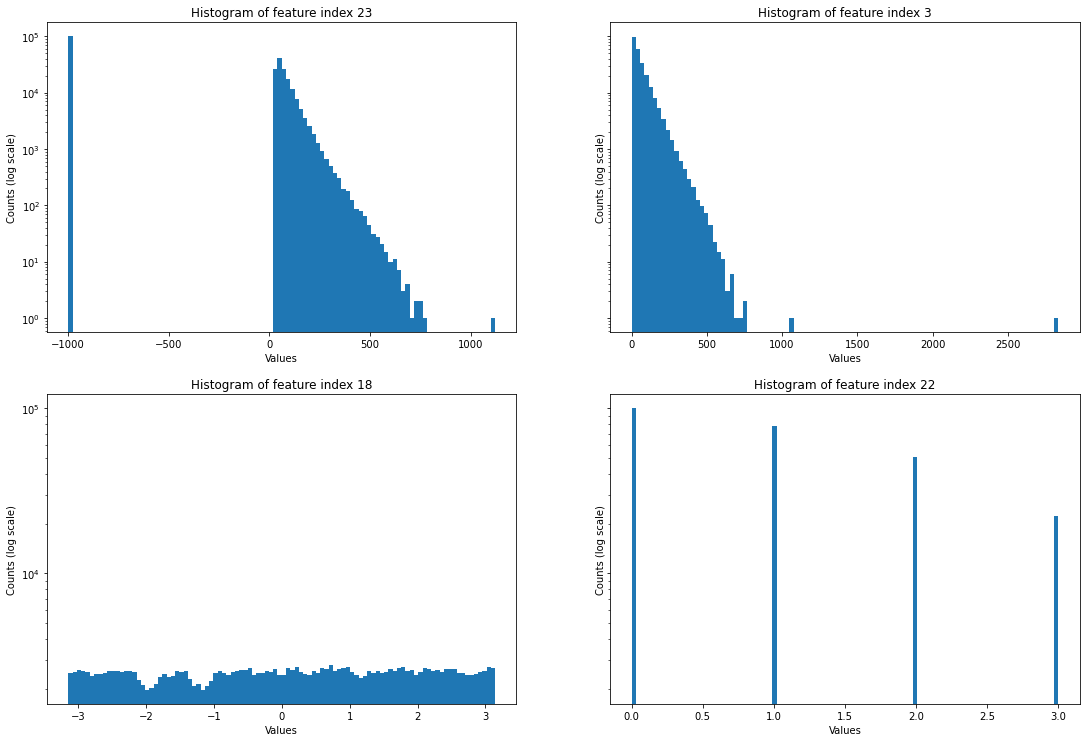

In [5]:
quad_histograms(x,23,3,18,22)

We can see that some features clearly have default values to -999, some seem to have extreme outliers (e.g. feature 3). We can also check that feature index 22 only has non negative integer values.

### Data cleaning

In [6]:
# Check if the values for the number of jets are non negative integers
# Column 22 corresponds to this variable
print(f'Number of negative values : {np.sum(x[:, 22] < 0)}')

Number of negative values : 0


In [7]:
# Check that no value in the table is a nan value
np.sum(x==np.nan)

0

We can see that we have 250'000 data points with 30 features each.

In [8]:
x.shape

(250000, 30)

In [9]:
np.sum(x == -999, axis=0)

array([ 38114,      0,      0,      0, 177457, 177457, 177457,      0,
            0,      0,      0,      0, 177457,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,  99913,
        99913,  99913, 177457, 177457, 177457,      0])

We can see that some of the features have a very high number of undefined values (-999). We could replace this undefined values by e.g. 0 or the mean of the remaining values but this would result in columns having its majority of entries (e.g. 177'000 / 250'000 $\approx$ 0.7) at the same value. This would imply that there is not a lot of variance in the feature and therefore this does not give much information about the label we want to predict. So we decided to drop the features where more than half of the rows are at -999.

In [10]:
# We remove the features where more than half of the rows are -999
x_cleaned, col_removed_training = remove_col_default_values(x)

In [11]:
col_removed_training

[4, 5, 6, 12, 26, 27, 28]

We can see that with this method we dropped 7 columns.

We also looked if some rows were having more than half of its features set to a default value (i.e. -999). In this case, there were no such rows.

In [12]:
check_nb_rows_default_features(x_cleaned)

Number of rows : 0


For the remaining default values, we decided to set them to -999. We did this instead of e.g. replacing them by the mean or median of the remaining values because we noted that the models actually performed better.

In [13]:
x_cleaned, default_values_training = replace_by_default_value(x_cleaned)

Some features represents angles, which are supposed to be in the range $[\pi; -\pi[$ according to the documentation of the dataset (https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf). Let's check this is the case.

In [14]:
cols_angle = [11, 14, 16, 21]
x_cleaned = check_all_azimuth_angles(x_cleaned, cols_angle)

Number of values outside [-pi;pi[ (col 11): 9
Number of values outside [-pi;pi[ (col 14): 11
Number of values outside [-pi;pi[ (col 16): 9
Number of values outside [-pi;pi[ (col 21): 3


We can see that some of the features have rows with azimuth outside the range. For these features indexes we deciced to put the non-valid values back in the $[-\pi; \pi[$ interval by taking the modulo $2 \pi$ and subtracting $\pi$.

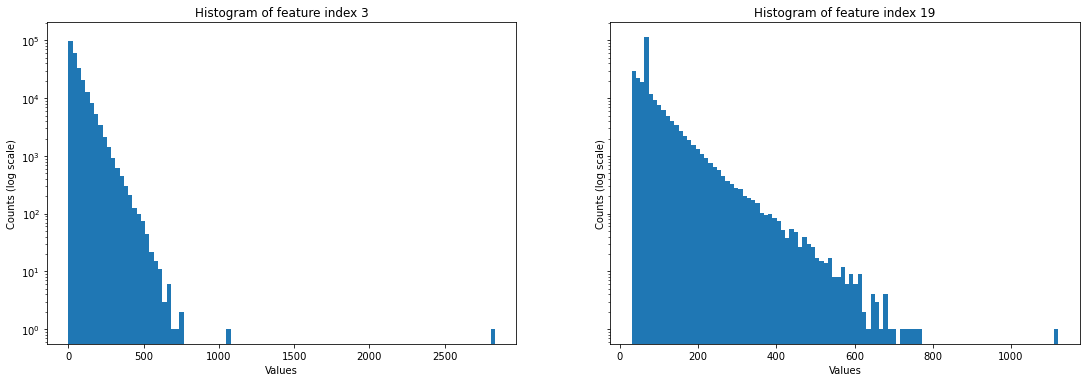

In [15]:
double_histograms(x_cleaned, 3,19)

#### Removing outliers
We can observe that in some features there still seems to be some outliers (e.g. see the histogram above for feature index 3).


We will deal with them using a method based on the Inter Quartile Range (IQR). 

In [16]:
x_cleaned, above_lim_training, below_lim_training = clip_IQR(x_cleaned)

In [17]:
cols_angle

[11, 14, 16, 21]

In [18]:
acc_local_test, f1_local_test, w_best = run_experiment(y, x_cleaned, 'reg_logistic_regression', 1, 0.8, cols_angle)

End of processing + expansion
Beginning training
Beginning cross-validation
Perform cross-validation for lambda=0.0000 and degree=2


KeyboardInterrupt: 

In [42]:
acc_local_test, f1_local_test, w_best, best_degree, best_lambda = run_experiment(y, x_cleaned, 'ridge_regression', 1, 0.8, cols_angle)

End of processing + expansion
Beginning training
Beginning cross-validation
Perform cross-validation for lambda=0.0000 and degree=2
Actual loss for lambda=0.0000 and degree=2. tr=0.7421749652268665, te=0.7443594017948946
Perform cross-validation for lambda=0.0000 and degree=2
Actual loss for lambda=0.0000 and degree=2. tr=0.7421749652268668, te=0.7443594017248654
Perform cross-validation for lambda=0.0000 and degree=2
Actual loss for lambda=0.0000 and degree=2. tr=0.7421749652268734, te=0.7443594013424651
Perform cross-validation for lambda=0.0000 and degree=2
Actual loss for lambda=0.0000 and degree=2. tr=0.7421749652270728, te=0.7443593992568758
Perform cross-validation for lambda=0.0000 and degree=2
Actual loss for lambda=0.0000 and degree=2. tr=0.7421749652330012, te=0.7443593878889946
Perform cross-validation for lambda=0.0000 and degree=2
Actual loss for lambda=0.0000 and degree=2. tr=0.742174965408581, te=0.7443593261741895
Perform cross-validation for lambda=0.0000 and degree=2

KeyboardInterrupt: 

End of processing + expansion
Beginning training
Beginning cross-validation
Perform cross-validation for lambda=0.0000 and degree=2


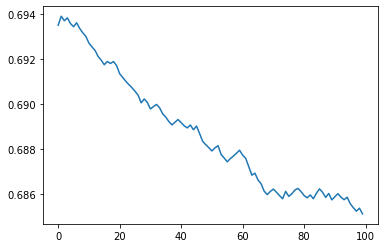

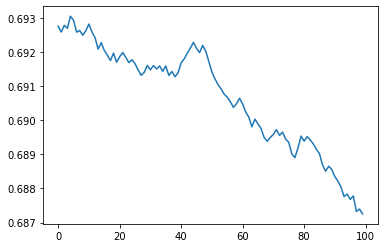

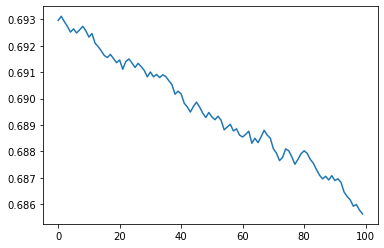

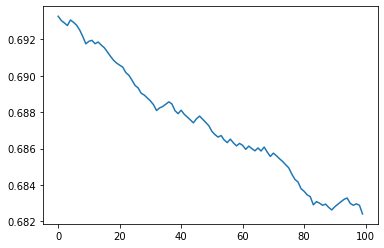

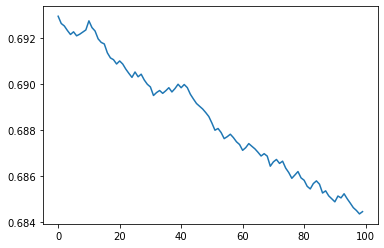

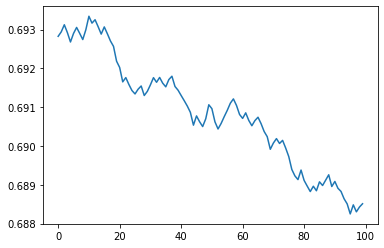

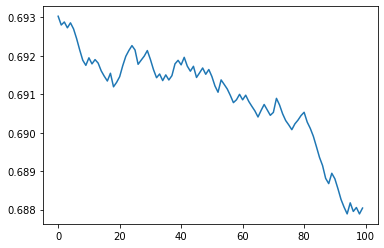

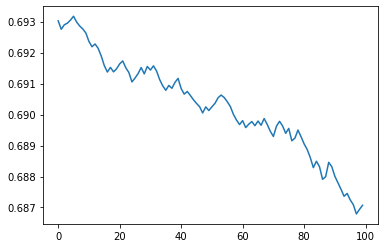

Actual loss for lambda=0.0000 and degree=2. tr=1.171372592815309, te=1.1713793288717294
Perform cross-validation for lambda=0.0000 and degree=2


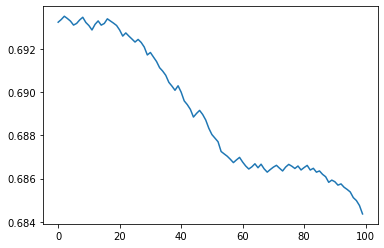

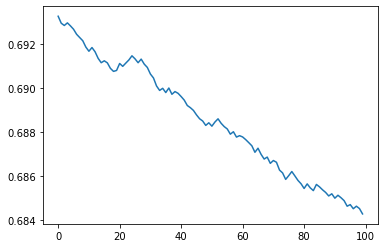

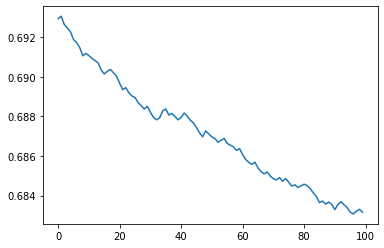

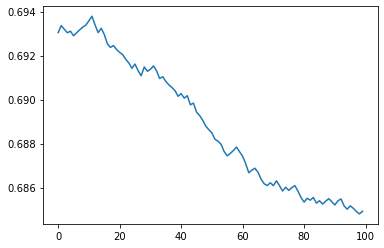

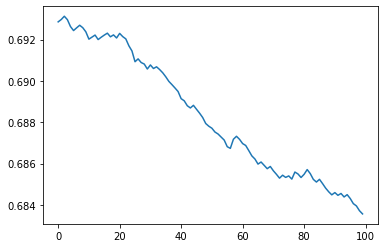

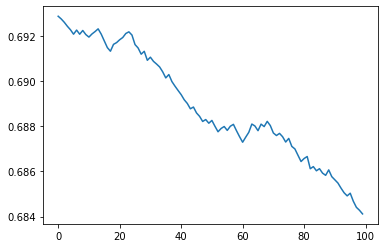

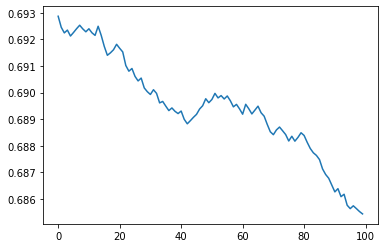

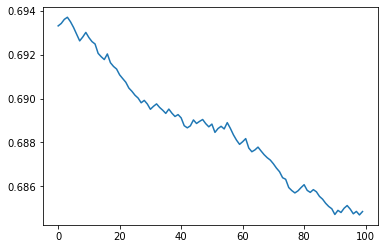

Actual loss for lambda=0.0000 and degree=2. tr=1.1699026397008665, te=1.1699072195783957
Perform cross-validation for lambda=0.0000 and degree=2


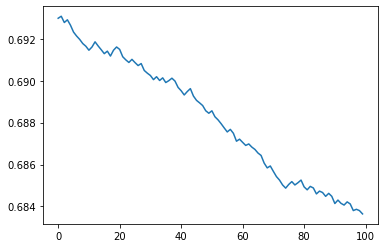

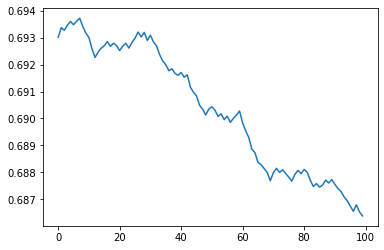

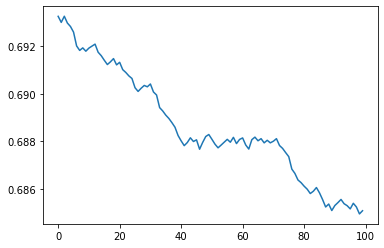

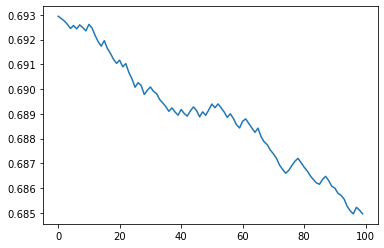

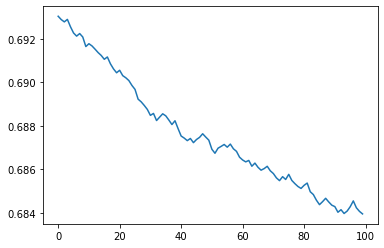

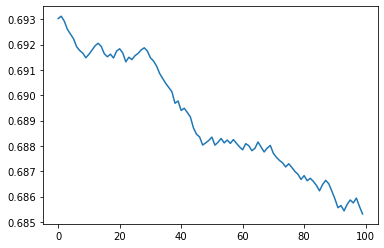

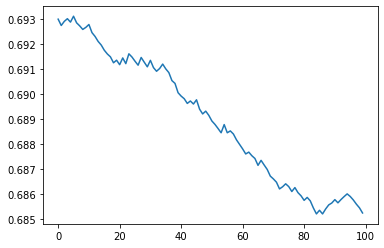

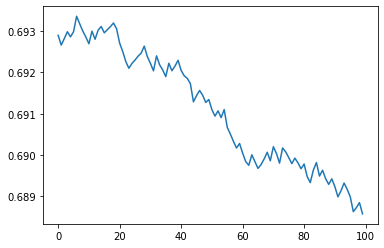

Actual loss for lambda=0.0000 and degree=2. tr=1.1708061679721318, te=1.1708145837669188
Perform cross-validation for lambda=0.0000 and degree=2


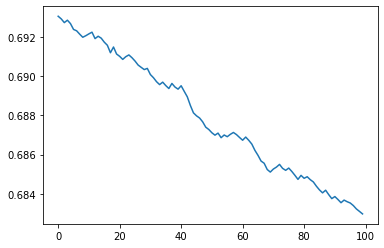

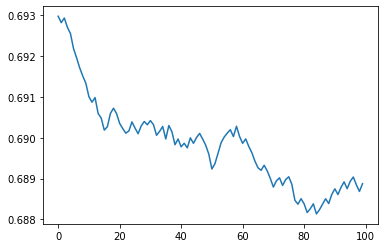

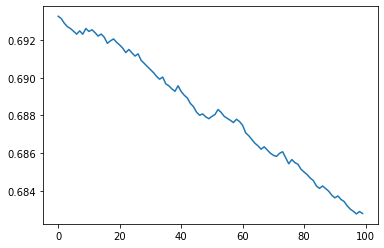

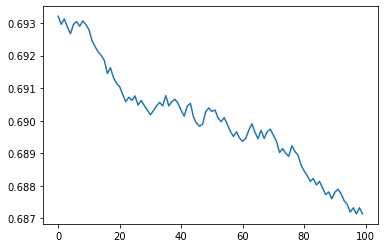

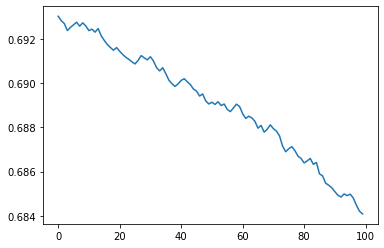

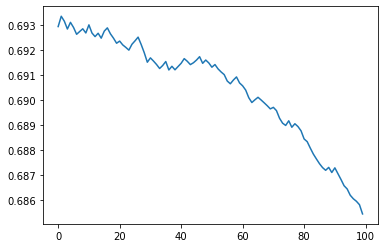

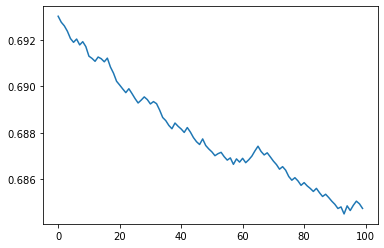

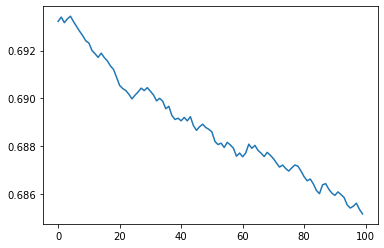

Actual loss for lambda=0.0000 and degree=2. tr=1.1705993206442946, te=1.1706080085515973
Perform cross-validation for lambda=0.0000 and degree=2


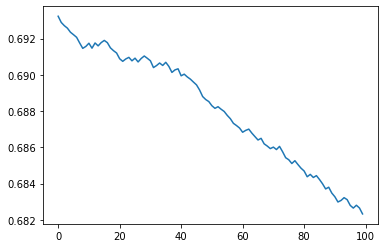

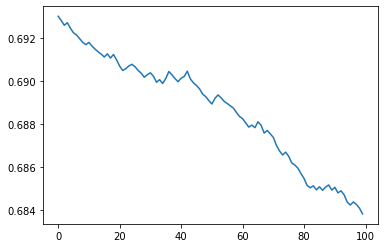

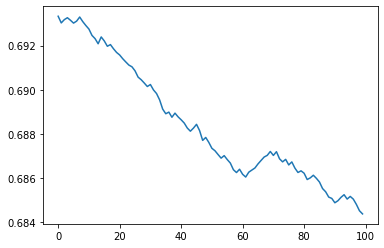

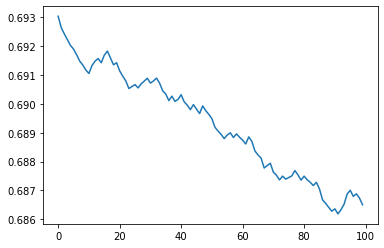

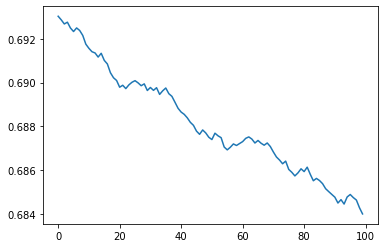

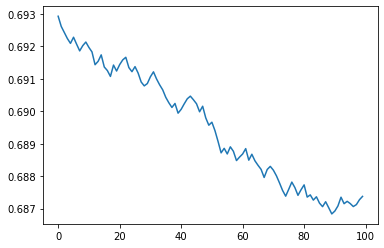

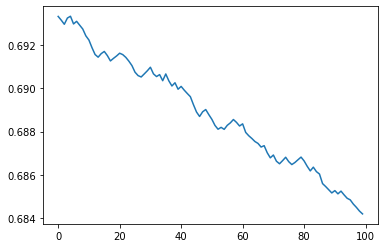

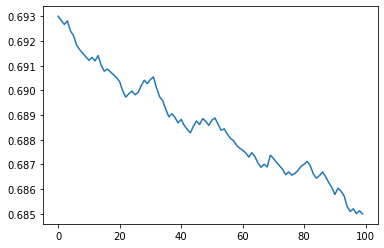

Actual loss for lambda=0.0000 and degree=2. tr=1.1702121295778676, te=1.1702386916631182
Perform cross-validation for lambda=0.0000 and degree=2


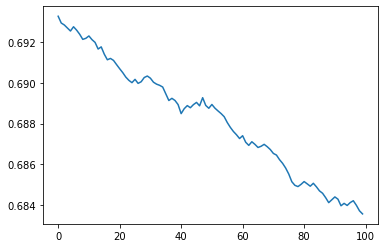

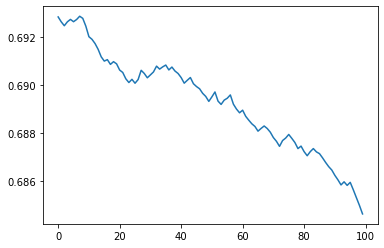

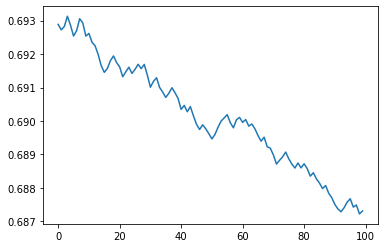

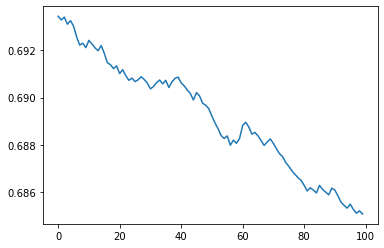

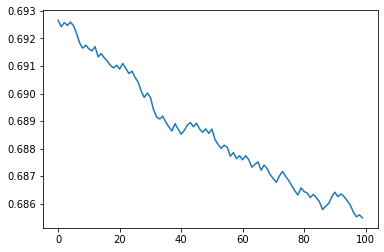

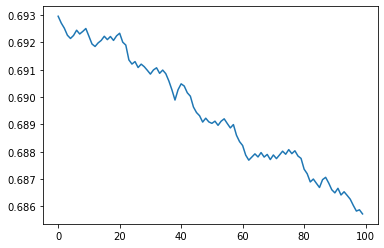

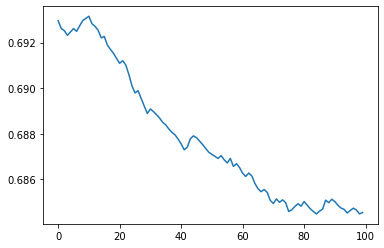

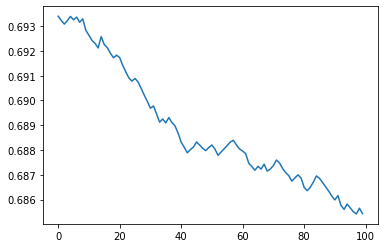

Actual loss for lambda=0.0000 and degree=2. tr=1.1706546273949248, te=1.1706703528774312
Perform cross-validation for lambda=0.0000 and degree=2


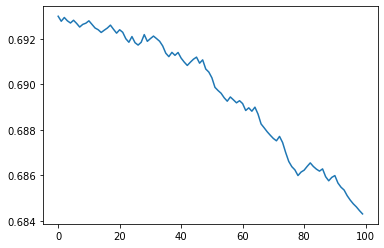

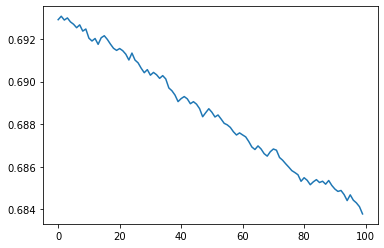

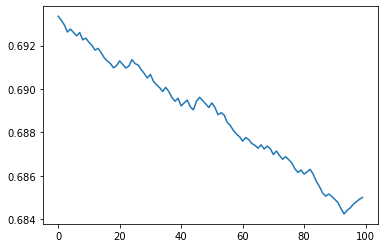

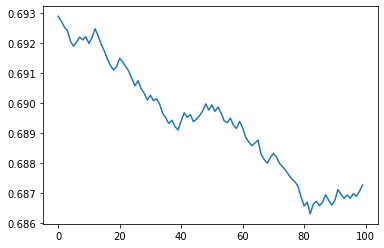

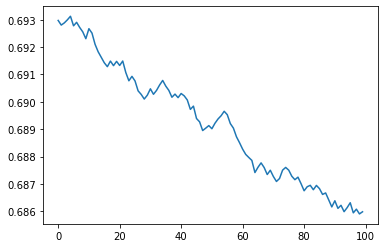

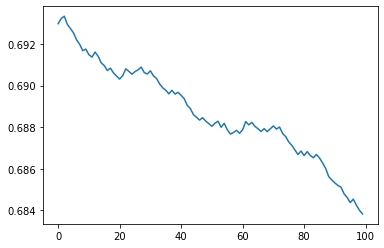

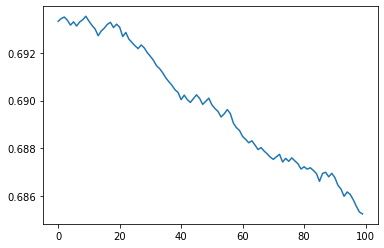

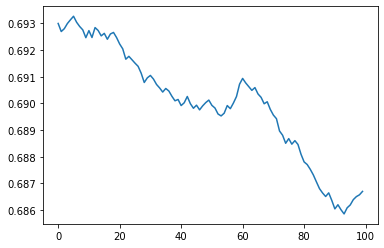

Actual loss for lambda=0.0000 and degree=2. tr=1.1706988348264151, te=1.170699561789839
Perform cross-validation for lambda=0.0000 and degree=2


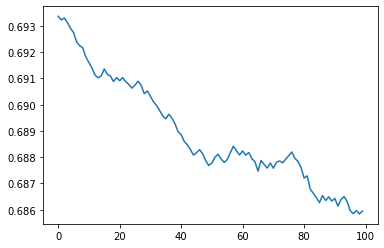

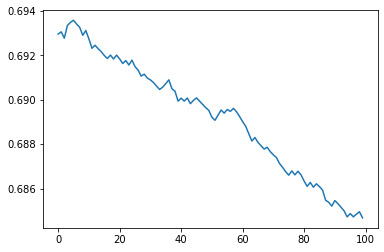

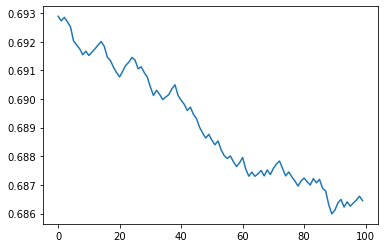

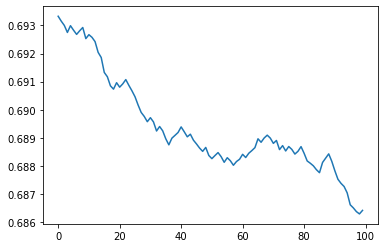

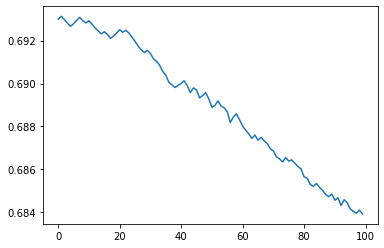

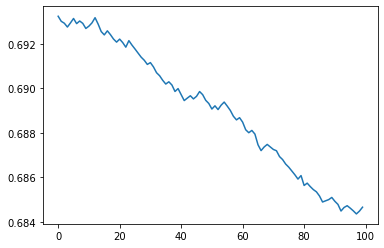

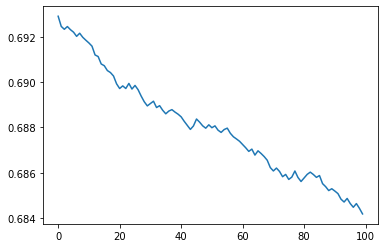

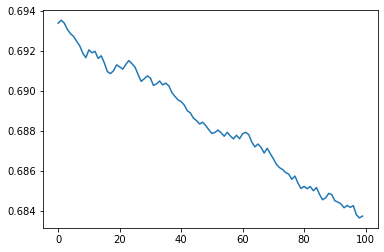

Actual loss for lambda=0.0000 and degree=2. tr=1.1704686745120845, te=1.1704530297884967
Perform cross-validation for lambda=0.0000 and degree=2


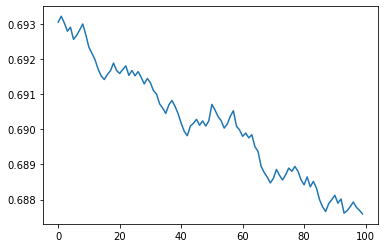

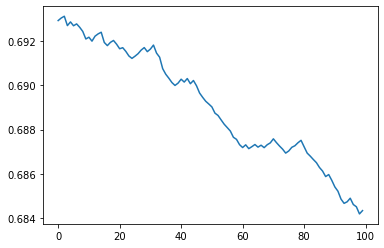

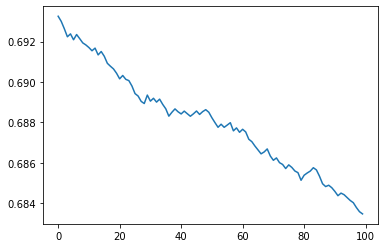

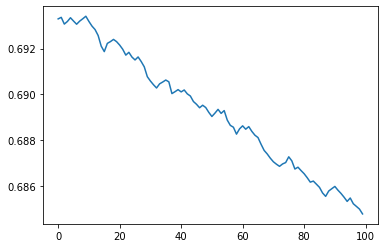

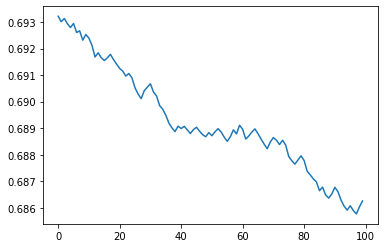

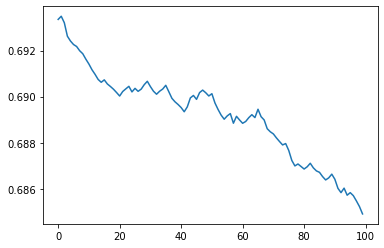

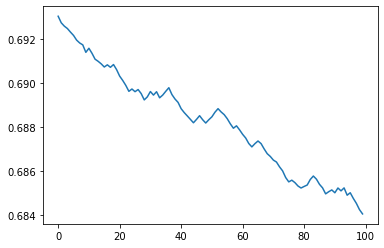

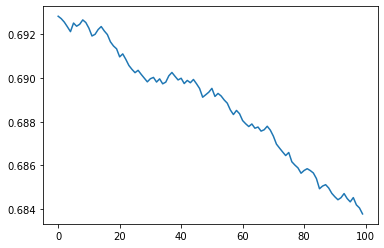

Actual loss for lambda=0.0000 and degree=2. tr=1.1703786278191823, te=1.1703654313302663
Perform cross-validation for lambda=0.0000 and degree=2


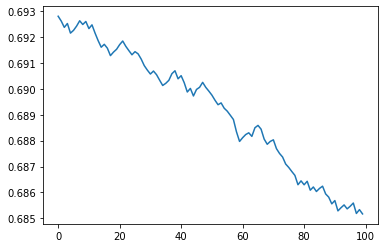

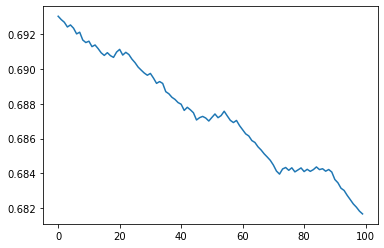

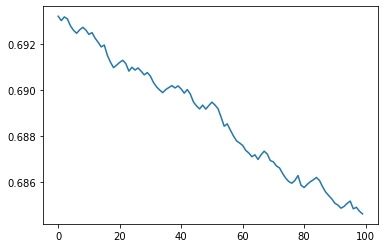

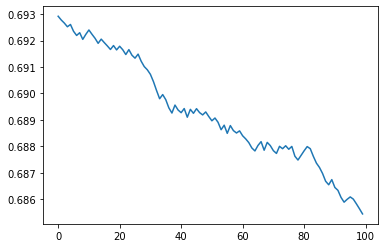

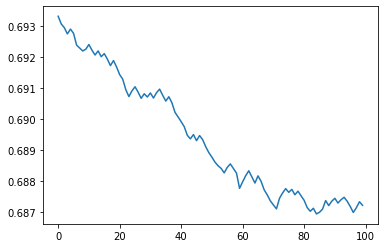

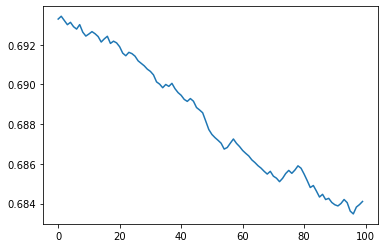

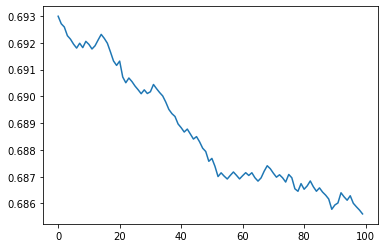

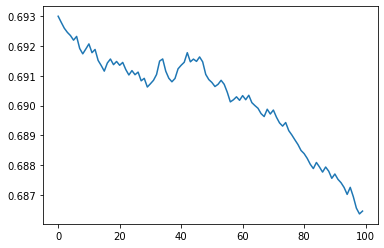

Actual loss for lambda=0.0000 and degree=2. tr=1.170500840863867, te=1.1705049109011183
Perform cross-validation for lambda=0.0000 and degree=2


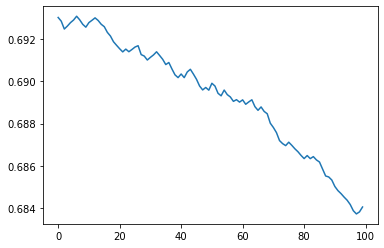

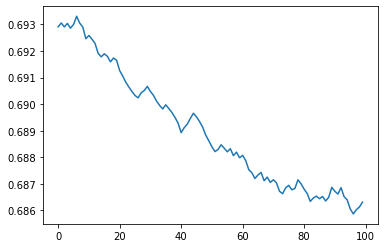

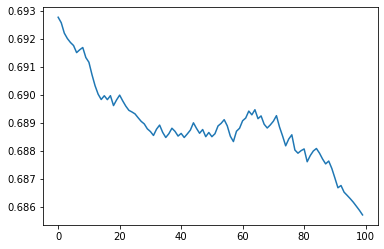

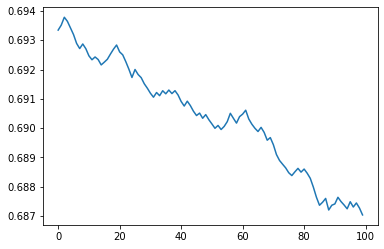

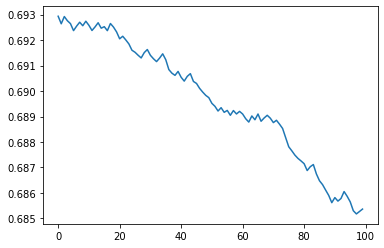

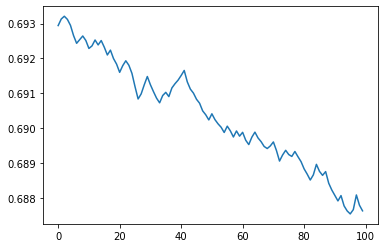

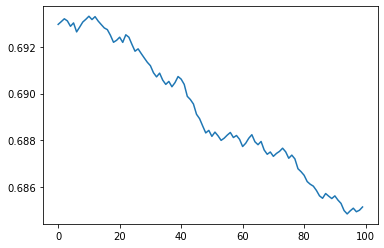

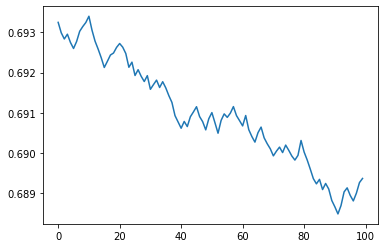

Actual loss for lambda=0.0000 and degree=2. tr=1.1716039209330882, te=1.1716000293721223
Perform cross-validation for lambda=0.0000 and degree=2


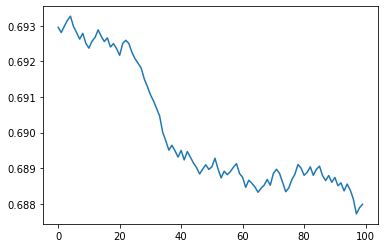

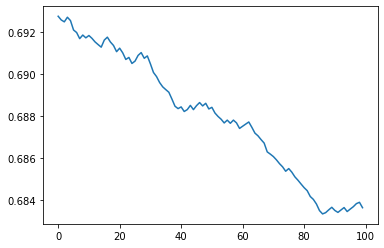

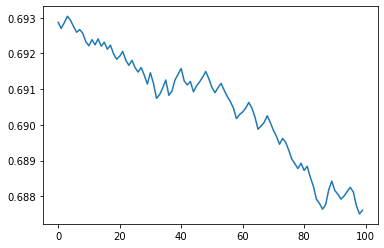

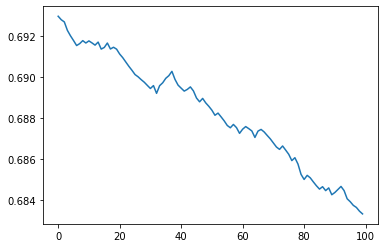

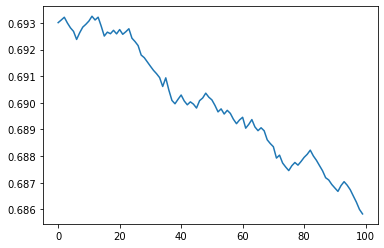

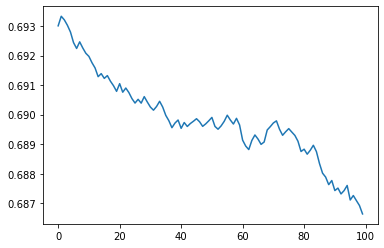

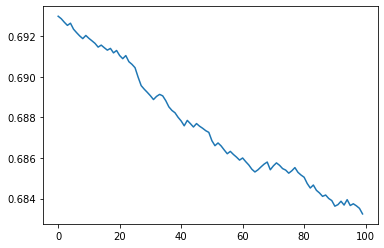

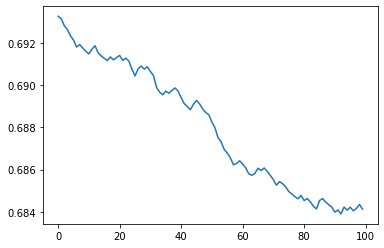

Actual loss for lambda=0.0000 and degree=2. tr=1.1707240751493895, te=1.170702063345749
Perform cross-validation for lambda=0.0000 and degree=2


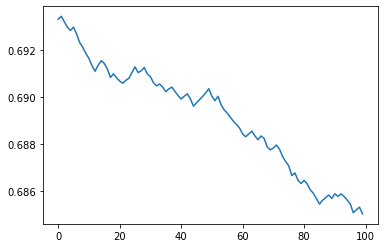

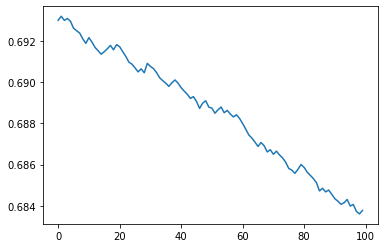

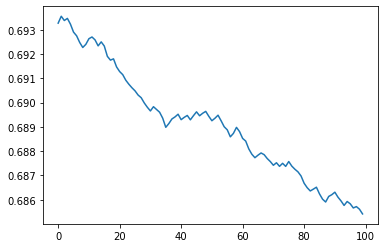

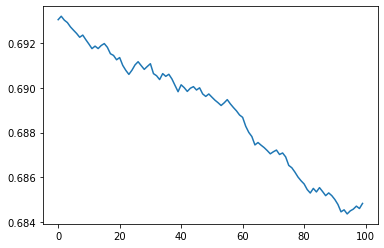

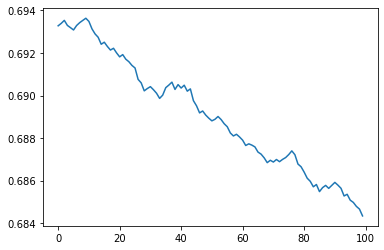

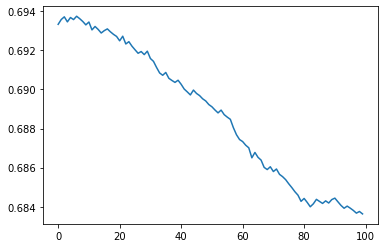

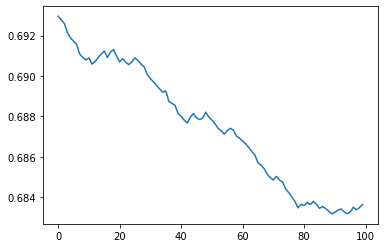

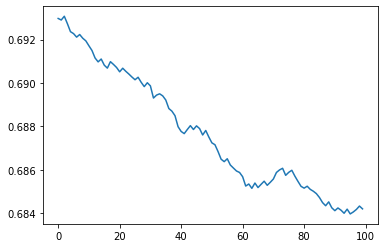

Actual loss for lambda=0.0000 and degree=2. tr=1.169920089428465, te=1.1699087537940693
Perform cross-validation for lambda=0.0000 and degree=2


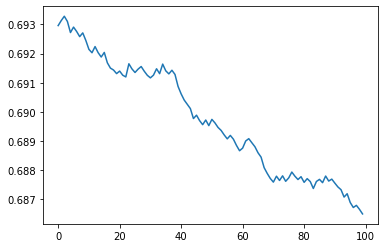

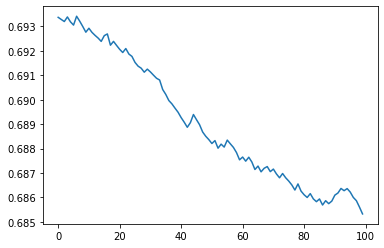

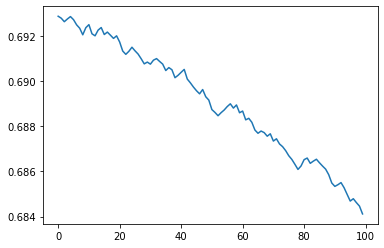

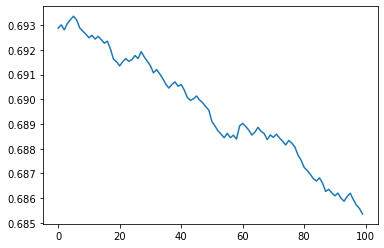

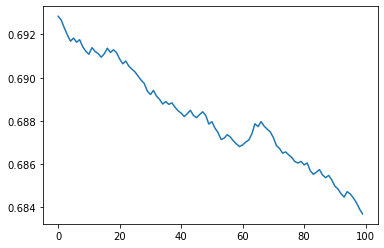

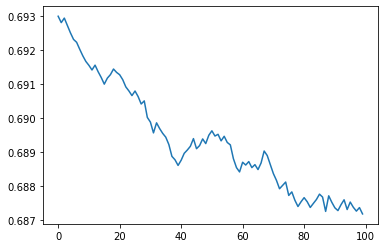

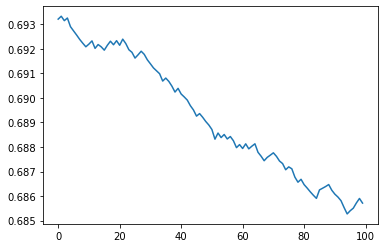

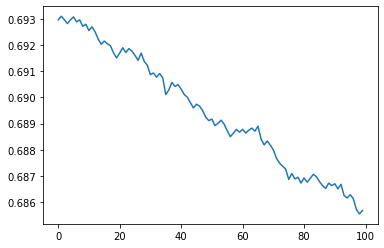

Actual loss for lambda=0.0000 and degree=2. tr=1.1708524983658593, te=1.1708470294065154
Perform cross-validation for lambda=0.0002 and degree=2


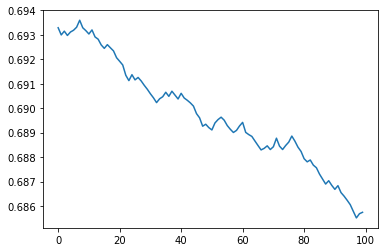

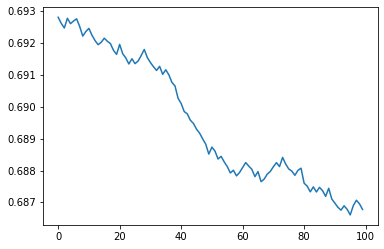

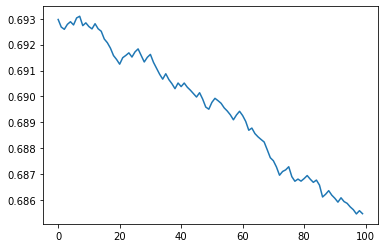

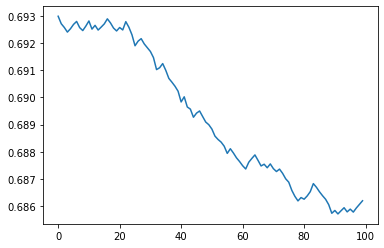

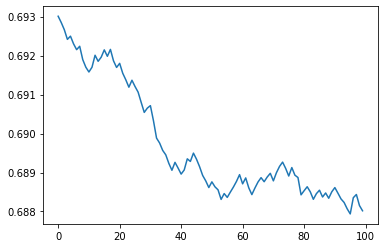

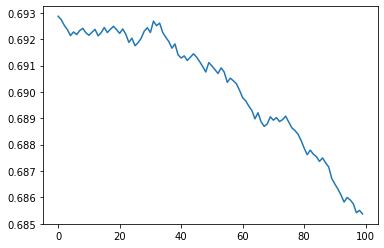

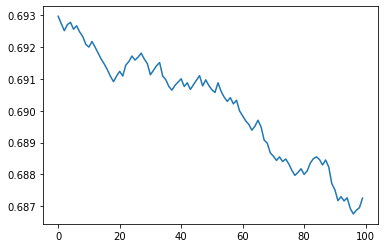

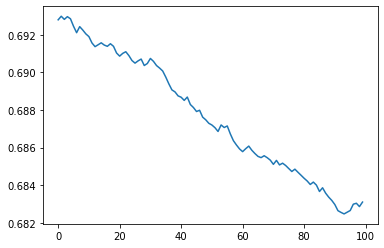

Actual loss for lambda=0.0002 and degree=2. tr=1.1713174146457423, te=1.1713280724799846
Perform cross-validation for lambda=0.0011 and degree=2


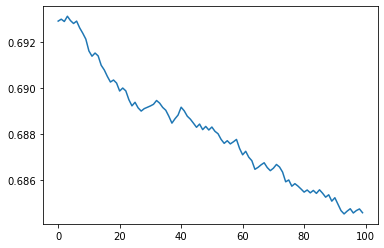

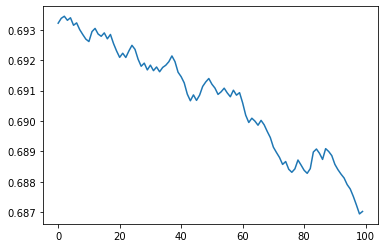

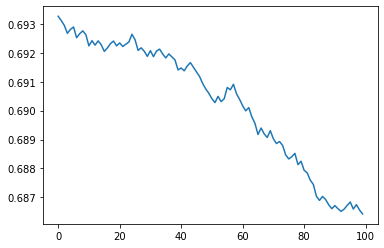

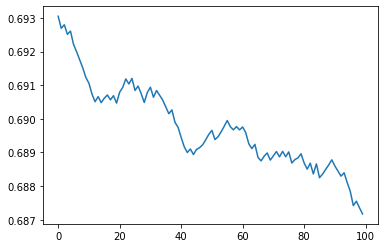

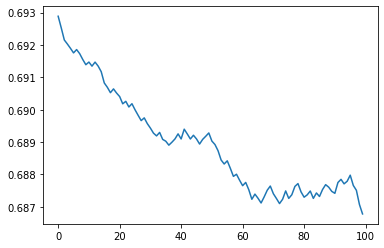

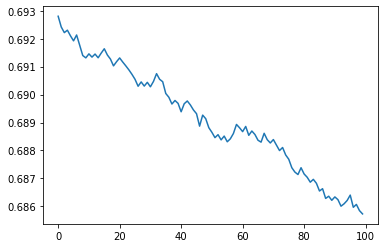

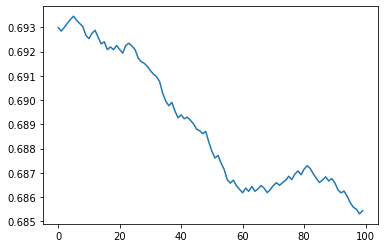

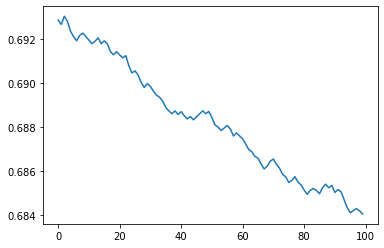

Actual loss for lambda=0.0011 and degree=2. tr=1.1712359912888042, te=1.1712470653315585
Perform cross-validation for lambda=0.0062 and degree=2


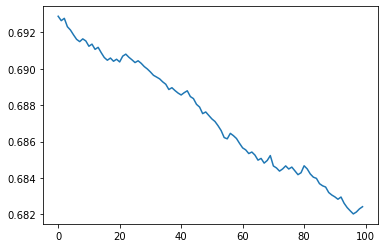

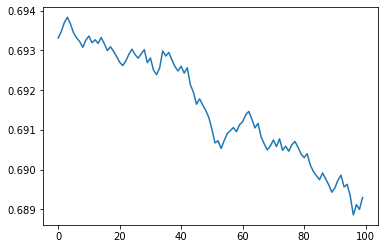

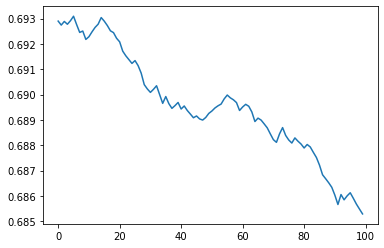

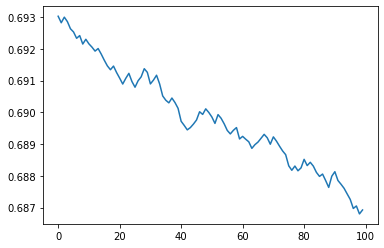

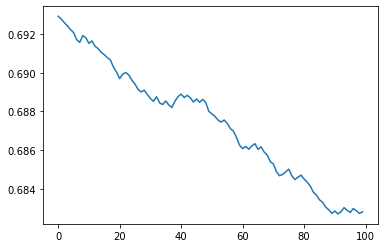

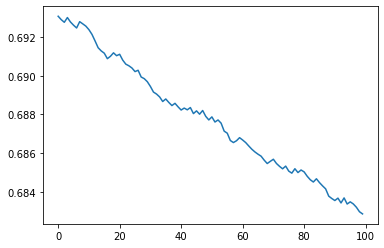

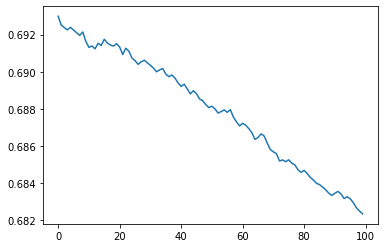

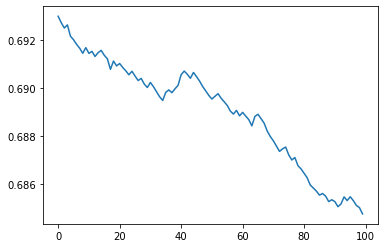

Actual loss for lambda=0.0062 and degree=2. tr=1.1701130443867807, te=1.1701173576620594
Perform cross-validation for lambda=0.0336 and degree=2


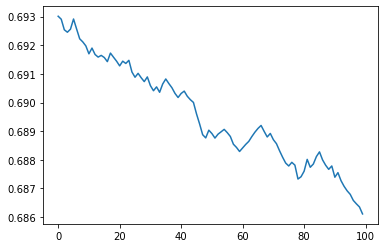

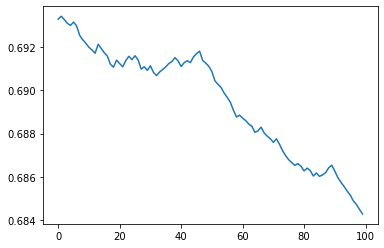

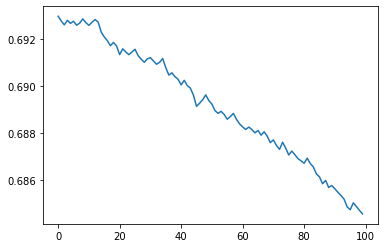

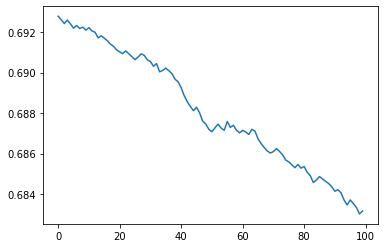

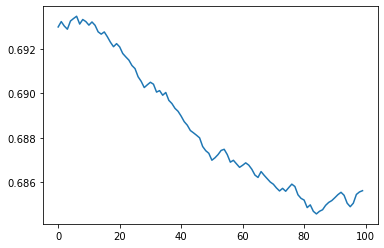

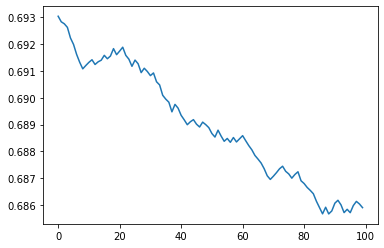

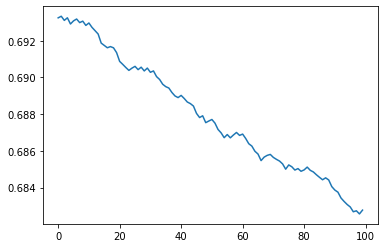

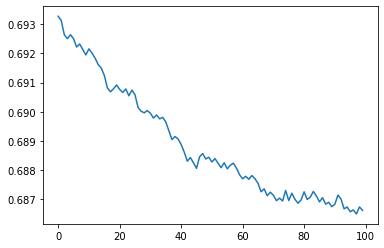

Actual loss for lambda=0.0336 and degree=2. tr=1.1703709355439977, te=1.1703535373620755
Perform cross-validation for lambda=0.1833 and degree=2


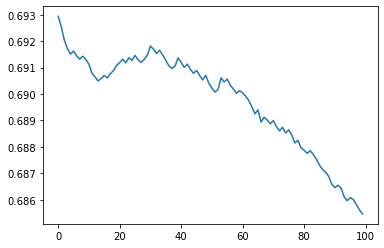

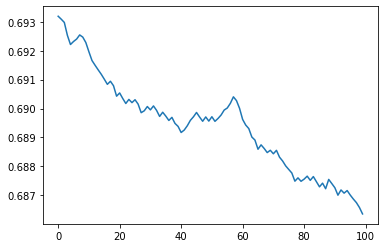

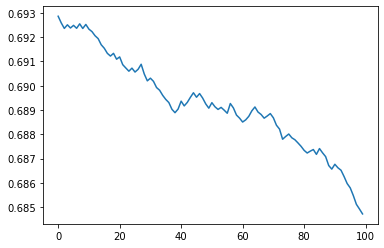

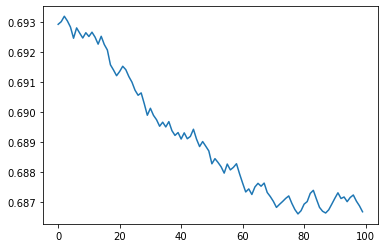

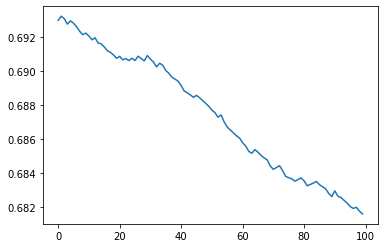

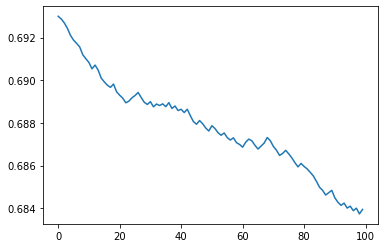

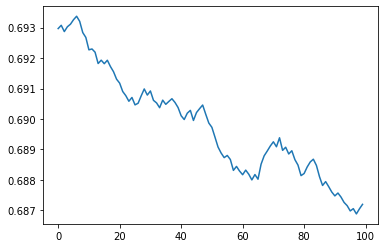

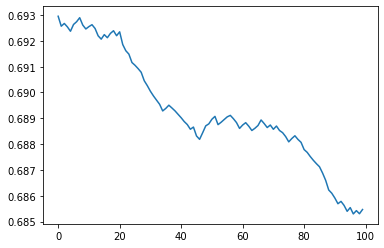

Actual loss for lambda=0.1833 and degree=2. tr=1.170621581635455, te=1.1705981779425723
Perform cross-validation for lambda=1.0000 and degree=2


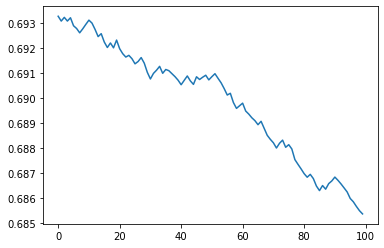

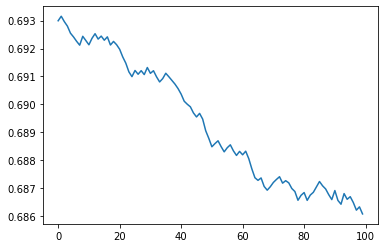

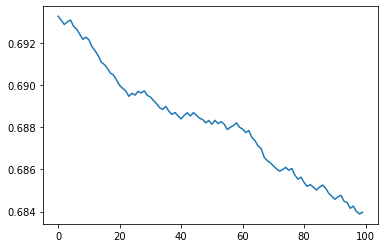

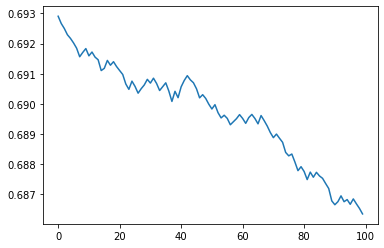

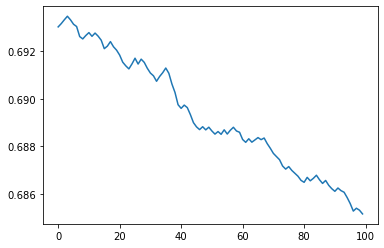

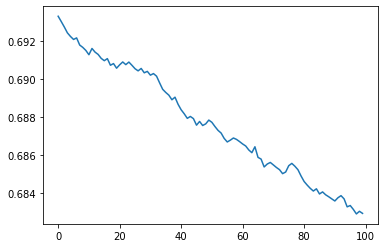

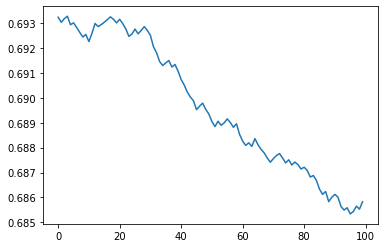

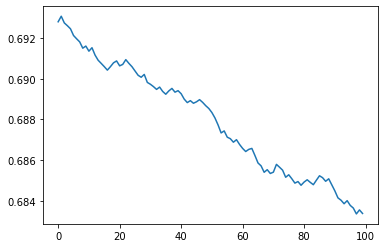

Actual loss for lambda=1.0000 and degree=2. tr=1.1703703156396, te=1.170397030329109
Perform cross-validation for lambda=0.0000 and degree=3


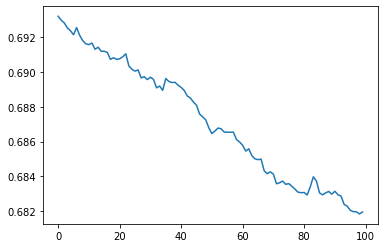

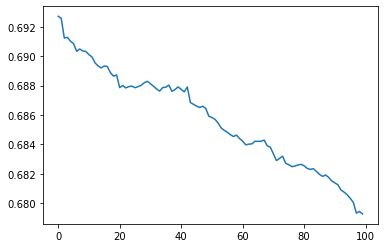

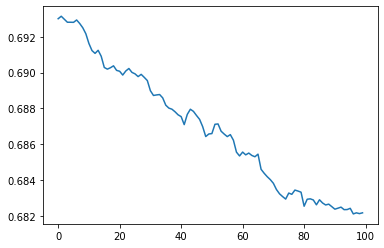

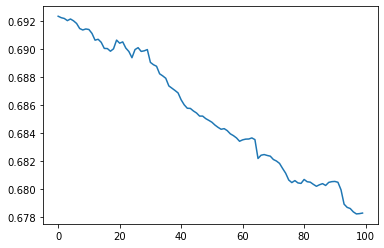

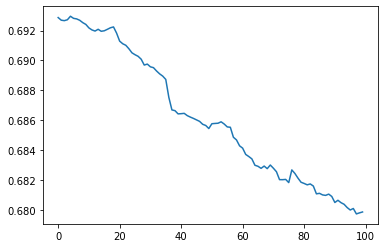

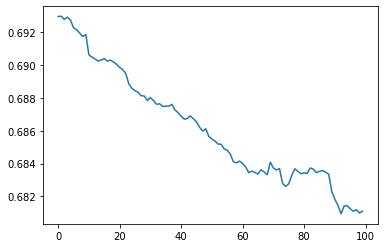

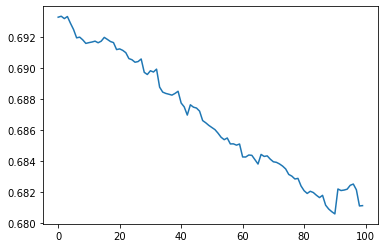

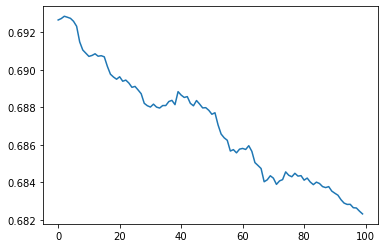

Actual loss for lambda=0.0000 and degree=3. tr=1.1668469942892719, te=1.1668139370793897
Perform cross-validation for lambda=0.0000 and degree=3


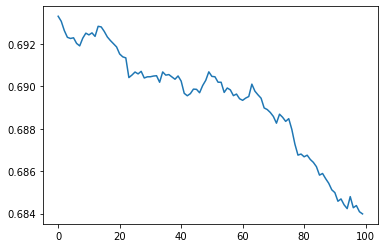

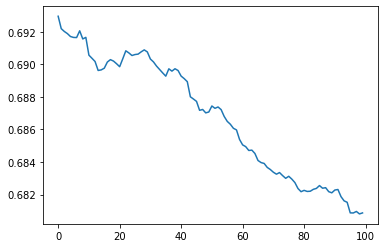

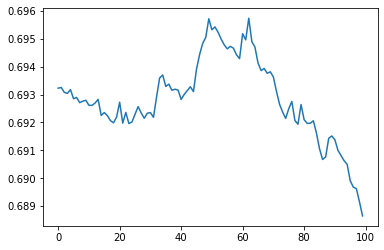

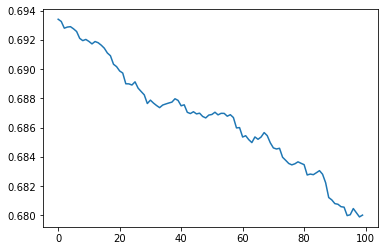

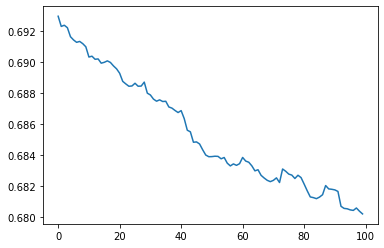

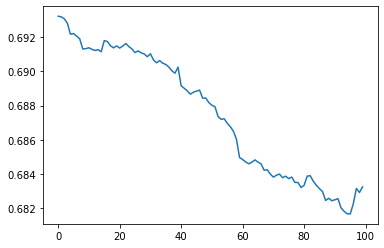

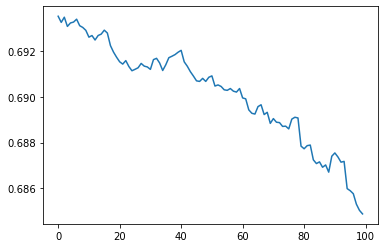

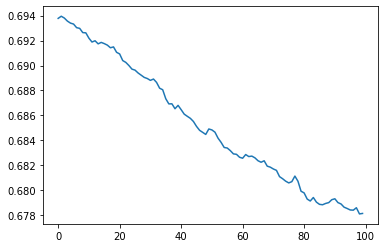

Actual loss for lambda=0.0000 and degree=3. tr=1.1683271864043936, te=1.1682942673518366
Perform cross-validation for lambda=0.0000 and degree=3


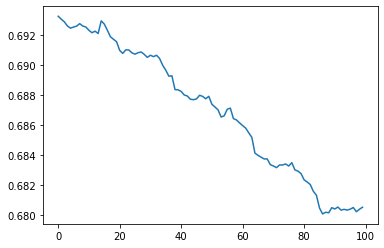

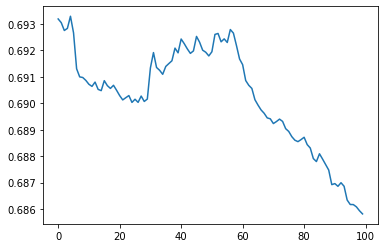

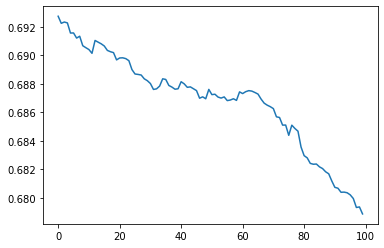

In [ ]:
acc_local_test, f1_local_test, w_best, best_degree, best_lambda = run_experiment(y, x_cleaned, 'reg_logistic_regression', 1, 0.8, cols_angle)

End of processing + expansion
Beginning training
Beginning cross-validation
Perform cross-validation for lambda=0.0000 and degree=2


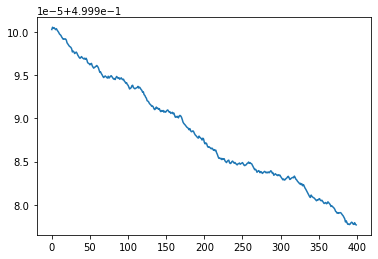

KeyboardInterrupt: 

In [45]:
acc_local_test, f1_local_test, w_best, best_degree, best_lambda = run_experiment(y, x_cleaned, 'least_squares_SGD', 1, 0.8, cols_angle,max_iters=400)

In [32]:
best_degree, best_lambda

(8, 0)

In [36]:
x_cleaned_std, means, stds = standardize(x_cleaned.copy())

In [37]:
# load and pre-process test data
test_path = 'data/test.csv'
x_te_cleaned, ids_test, y_test = process_test_set(test_path, col_removed_training, default_values_training, above_lim_training, below_lim_training, means, stds, cols_angle, best_degree)

Number of values outside [-pi;pi[ (col 11): 19
Number of values outside [-pi;pi[ (col 14): 17
Number of values outside [-pi;pi[ (col 16): 22
Number of values outside [-pi;pi[ (col 21): 9


In [38]:
# Predict the lab and output the result in the CSV files
#y_test_pred = predict_labels_logistic_regression(w_best, x_te_cleaned)

y_test_pred = predict_labels(w_best, x_te_cleaned)
create_csv_submission(ids_test, y_test_pred, 'log.csv')

In [22]:
power_exp(np.array([[1,2],[2,3]]),3)

array([[ 1,  2,  4,  8],
       [ 2,  3,  9, 27]])